# Freq / Rec Analysis & CLV Calculation in Non-Contractual Business

**The following analysis is conducted in Python using the [Lifetimes](https://github.com/CamDavidsonPilon/lifetimes) package developed by Cameron Davidson-Pilon, data scientist at Shopify.**

### Import libraries, load data

In [102]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt

from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *


from lifetimes import BetaGeoFitter

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(), sns.set_style('whitegrid')
%matplotlib inline  

# special settings for lifetime plots
sns.set_palette("viridis")
sns.set(rc={'image.cmap': 'viridis'})

import cleaning_functions as clean
import EDA_functions as EDA

# display of all columns in df - check if pd option below isn't better
from IPython.display import display
pd.options.display.max_columns = None

In [22]:
# load data
data = pd.read_excel("OnlineRetail.xlsx")

### Assess Data

In [23]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [113]:
# change dtype for customerID to object
clv_data = clean.change_dtypes(data.copy(), cols_to_object=['CustomerID'])

# normalize InvoiceDate to dates (remove time)
clv_data['InvoiceDate'] = clv_data['InvoiceDate'].dt.date

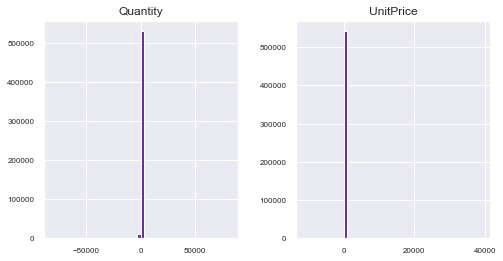

In [114]:
# check distribution of numerical data
EDA.plot_num_hist(clv_data, figsize=(8,4))

In [115]:
# check characteristics of numeric data
clv_data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [116]:
print("neg Quantities: ", len(clv_data.loc[clv_data['Quantity'] <= 0]))
print("neg unitPrices: ", len(clv_data.loc[clv_data['UnitPrice'] <= 0]))

neg Quantities:  10624
neg unitPrices:  2517


In [117]:
# check characteristics of object data
clv_data.describe(include = 'object')

,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country
count,541909,541909,540455,541909,541909,541909
unique,25900,4070,4223,305,4373,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-05,nan,United Kingdom
freq,1114,2313,2369,5331,135080,495478


**Note:** For Lifetimes we need an Input Dataframe of transaction data of the form: 
- customer_id
- datetime 
- [monetary_value] (optional, needed for clv estimations only)



**Need for cleaning:**
- drop orders with quantities <= 0
- drop orders with unit_price <= 0
- drop orders with missing customer ID
- add new column sales (quant * price)
- drop cols we won't need no more: InvoiceNo, Description, Country, StockCode, Quantity, Price

### Clean & Transform Data

In [118]:
"""clean according to list"""

clv_data = clv_data.loc[clv_data['CustomerID'] != 'nan']
clv_data = clv_data.loc[clv_data['Quantity'] > 0]
clv_data = clv_data.loc[clv_data['UnitPrice'] > 0]
clv_data['Sales'] = clv_data['Quantity'] * clv_data['UnitPrice']
clv_data.drop(['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice', 
    'Description', 'Country'], inplace=True, axis=1)

assert clv_data.isnull().sum().sum() == 0, "NaN in the Set"

In [119]:
# check results
print(clv_data.shape)
display(clv_data.head())

(397884, 3)


,InvoiceDate,CustomerID,Sales
0,2010-12-01,17850.0,15.30
1,2010-12-01,17850.0,20.34
2,2010-12-01,17850.0,22.00
3,2010-12-01,17850.0,20.34
4,2010-12-01,17850.0,20.34


In [120]:
"""transform dataframe"""

clv = summary_data_from_transaction_data(clv_data, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales')
# check results
print(clv.shape)
clv.head()

(4338, 4)


,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


**Nomenclature for the CLV model:**

- _Frequency_: represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. (Thus if they have made only 1 purchase, the recency is 0.)
- _T_: represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- _Recency_: represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

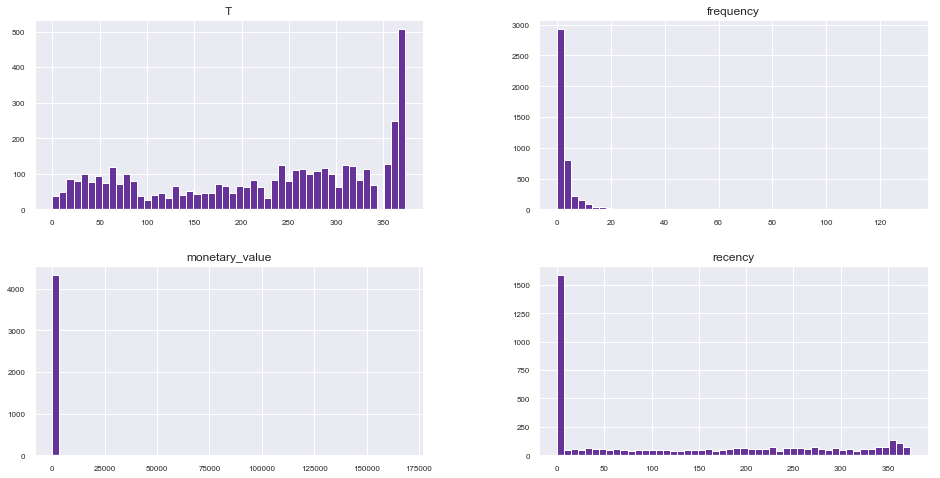

In [121]:
"""assess data"""

EDA.plot_num_hist(clv, figsize=(16,8))

In [122]:
print("prop of customers without repeat purchase: ", round(clv['frequency'].value_counts()[0]/len(clv),3))

prop of customers without repeat purchase:  0.357


## Basic Frequency / Recency Analysis Using the BG / NBD Model

In [123]:
"""fit BG model""" # note: similar API to scikit-learn and lifelines.

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.95, b: 2.03, r: 0.83>


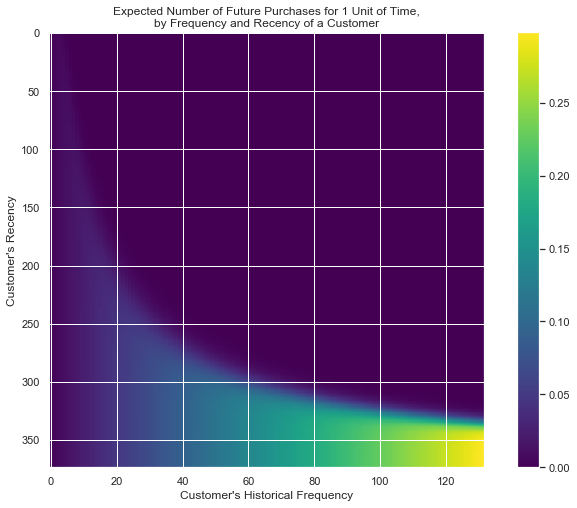

In [124]:
# plot frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf);

**Explanation:** Consider a customer bought from you every day for three weeks straight, and we haven’t heard from them in months. What are the chances they are still “alive”? Pretty small. On the other hand, a customer who historically buys from you once a quarter, and bought last quarter, is likely still alive. We can visualize this relationship using the Frequency/Recency matrix, which computes the expected number of transactions a artificial customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made).

- Our best customer is one that has made 250 purchases, and his latest purchase was when he was approximately 350 days old (bottom-right). Customers who have purchased a lot and purchased recently will likely be the best customers in the future. 
- Customers who have purchased a lot in the past but we have not heard them for long are the 'coldest', they have probably churned away (top-right corner).
- There’s also that beautiful “tail” around (40, 300). That represents the customer who buys infrequently, but we’ve seen him or her recently, so they might buy again - we’re not sure if they are dead or just between purchases.

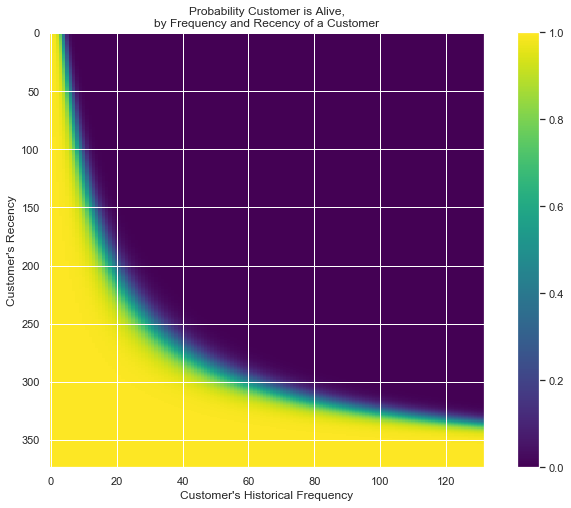

In [126]:
# plot probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf);

### Ranking customers from best to worst

Let’s rank our customers them from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [128]:
t = 1  # setting period for prediction
clv['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
    clv['frequency'], clv['recency'], clv['T'])

#check results
clv.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.401967
15311.0,89.0,373.0,373.0,677.729438,0.406494
17841.0,111.0,372.0,373.0,364.452162,0.506050
12748.0,112.0,373.0,373.0,301.024821,0.510577
14911.0,131.0,372.0,373.0,1093.661679,0.596557


### Assess model fit

There are a few ways to assess the model’s correctness. The first is to compare your data versus artificial data simulated with your fitted model’s parameters. We can see that our actual data and our simulated data line up well. This proves that our model doesn’t suck.

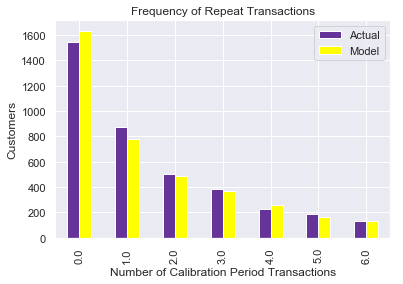

In [131]:
plot_period_transactions(bgf, color=['rebeccapurple', 'yellow']);

## Fit model with holdout set

With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature). Lifetimes has a function to partition our dataset like this:

In [134]:
"""fit model with calibration and holdout sets"""

summary_cal_holdout = calibration_and_holdout_data(clv_data, 'CustomerID', 'InvoiceDate', 
                                                   monetary_value_col='Sales',
                                                   calibration_period_end='2011-06-08',
                                                   observation_period_end='2011-12-9')   

In [135]:
# check results
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  monetary_value_cal  \
CustomerID                                                          
12346.0               0.0          0.0  141.0                0.00   
12347.0               2.0        121.0  183.0              555.82   
12348.0               2.0        110.0  174.0              297.22   
12350.0               0.0          0.0  126.0                0.00   
12352.0               3.0         34.0  112.0              421.77   

            frequency_holdout  monetary_value_holdout  duration_holdout  
CustomerID                                                               
12346.0                   0.0                0.000000               184  
12347.0                   4.0               25.373163               184  
12348.0                   1.0              103.333333               184  
12350.0                   0.0                0.000000               184  
12352.0                   3.0               20.090000               184 

In [ ]:
"""fit on the _cal columns, and test on the _holdout columns"""

bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])

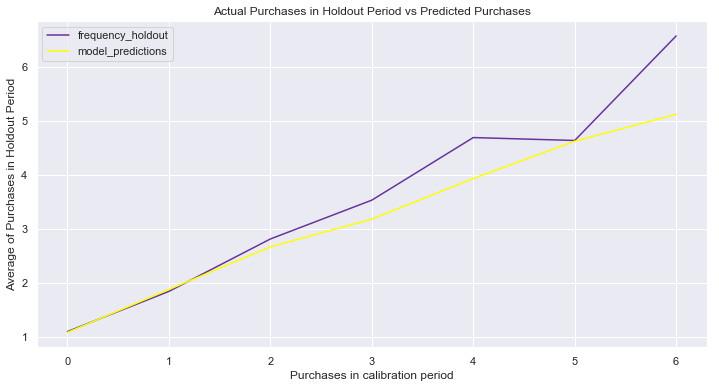

In [139]:
# plot results
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, figsize=(12,6),
                                                color=['rebeccapurple', 'yellow']);

In [44]:
t = 10 # predict purchases in 10 periods
individual = data.loc[12347]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.1572775101289126

In [17]:
data.loc[12347]

frequency                6.000000
recency                365.000000
T                      367.000000
monetary_value         599.701667
predicted_purchases      0.015657
Name: 12347.0, dtype: float64

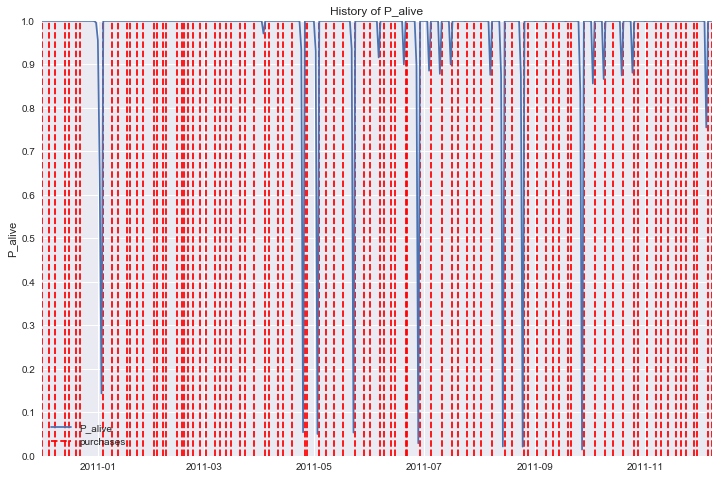

In [45]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

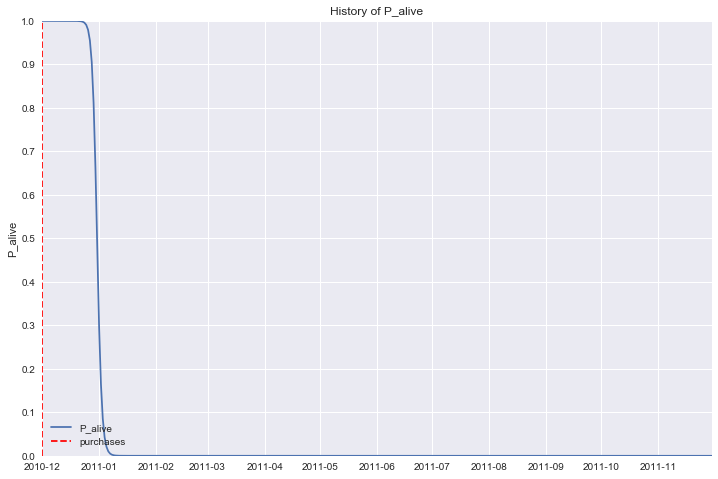

In [46]:
fig = plt.figure(figsize=(12,8))
id = 14729
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

In [51]:
returning_customers_summary = data[data['frequency']>0]

print(returning_customers_summary.head())
print(len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.015657
12348.0           3.0    283.0  358.0      301.480000             0.008960
12352.0           6.0    260.0  296.0      368.256667             0.018701
12356.0           2.0    303.0  325.0      269.905000             0.007173
12358.0           1.0    149.0  150.0      683.200000             0.008339
2790


In [26]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


In [52]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [53]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917686
12347.0    569.988813
12348.0    333.762675
12349.0    416.917686
12350.0    416.917686
12352.0    376.166866
12353.0    416.917686
12354.0    416.917686
12355.0    416.917686
12356.0    324.008944
dtype: float64


In [1]:
bgf.fit(data['frequency'], data['recency'], data['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

NameError: name 'bgf' is not defined